In [27]:
import mlflow
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, fbeta_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import lightgbm as lgb

from mlflow.models import infer_signature

import shap
# Memory management
import gc 

Pour cette partie, je me suis inspirée de ce NB : https://www.kaggle.com/code/willkoehrsen/introduction-to-feature-selection

# 6 - Feature Selection
-------------

Nous avons à ce stade plus de 1300 features, ce qui est beaucoup trop. Les features non pertinentes, les features fortement corrélées et les valeurs manquantes peuvent empêcher le modèle d'apprendre et diminuer les performances de généralisation sur les données de test. C'est pourquoi nous procédons à une sélection des features afin de ne conserver que les variables les plus utiles.

Nous commencerons la sélection des features en nous concentrant sur les variables colinéaires.

In [28]:
df_train=pd.read_csv('train_after_fe.csv')
df_test=pd.read_csv('test_after_fe.csv')

In [29]:
df_train.shape, df_test.shape

((307511, 1329), (48744, 1328))

In [30]:
df_train['NAME_EDUCATION_TYPE'].unique()

array(['Secondary / secondary special', 'Higher education',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

## 6.1 - Suppression des variables colinéaires

Les variables colinéaires sont celles qui sont fortement corrélées entre elles. Elles peuvent diminuer la disponibilité du modèle pour l'apprentissage, diminuer l'interprétabilité du modèle et diminuer les performances de généralisation sur l'ensemble de test. Il est clair que ce sont là trois choses que nous voulons augmenter, et la suppression des variables colinéaires est donc une étape utile. Nous établirons un seuil arbitraire pour la suppression des variables colinéaires, puis nous enlèverons une des paires de variables qui se trouvent au-dessus de ce seuil.

Le code ci-dessous identifie les variables fortement corrélées sur la base d'un coefficient de corrélation de Pearson > 0,9.

### 6.1.1 - Identification des variables corrélées

Comme le dataframe est très gros, nous allons faire ce travail sur un échantillon de 1000 individus

In [31]:
df_sample=df_train.sample(1000)
df_sample.shape

(1000, 1329)

In [32]:
# Threshold for removing correlated variables
threshold = 0.9

# Exclude non-numeric columns
numeric_cols = df_sample.select_dtypes(include=[np.number])

# Calculate the absolute value of the correlation matrix
corr_matrix = numeric_cols.corr().abs()

# Display the correlation matrix
corr_matrix.head()


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
SK_ID_CURR,1.000000,0.026512,0.027804,0.002194,0.062286,0.078166,0.063725,0.041570,0.019500,0.022662,...,0.026534,0.013872,0.034475,0.039252,0.023913,0.025015,0.019580,0.018982,0.048746,0.046594
TARGET,0.026512,1.000000,0.065469,0.002581,0.003464,0.013484,0.017590,0.061012,0.048565,0.071879,...,0.013818,0.020960,0.040727,0.043544,0.050715,0.053208,0.099309,0.097997,0.016085,0.016175
CNT_CHILDREN,0.027804,0.065469,1.000000,0.008540,0.017314,0.011509,0.022087,0.023668,0.346759,0.060849,...,0.051105,0.020432,0.018559,0.015364,0.031854,0.032057,0.005884,0.005890,0.015789,0.015280
AMT_INCOME_TOTAL,0.002194,0.002581,0.008540,1.000000,0.389673,0.457147,0.402857,0.203316,0.092222,0.000851,...,0.224462,0.217547,0.294669,0.293788,0.266818,0.257633,0.173033,0.173467,0.188712,0.181071
AMT_CREDIT,0.062286,0.003464,0.017314,0.389673,1.000000,0.781309,0.985193,0.119544,0.067982,0.058059,...,0.092499,0.056832,0.120489,0.093876,0.096595,0.079346,0.056264,0.057933,0.038090,0.030303


In [33]:
# On ne récupère que la partie haute de la matrice
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
upper.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
SK_ID_CURR,NaN,0.026512,0.027804,0.002194,0.062286,0.078166,0.063725,0.041570,0.019500,0.022662,...,0.026534,0.013872,0.034475,0.039252,0.023913,0.025015,0.019580,0.018982,0.048746,0.046594
TARGET,NaN,NaN,0.065469,0.002581,0.003464,0.013484,0.017590,0.061012,0.048565,0.071879,...,0.013818,0.020960,0.040727,0.043544,0.050715,0.053208,0.099309,0.097997,0.016085,0.016175
CNT_CHILDREN,NaN,NaN,NaN,0.008540,0.017314,0.011509,0.022087,0.023668,0.346759,0.060849,...,0.051105,0.020432,0.018559,0.015364,0.031854,0.032057,0.005884,0.005890,0.015789,0.015280
AMT_INCOME_TOTAL,NaN,NaN,NaN,NaN,0.389673,0.457147,0.402857,0.203316,0.092222,0.000851,...,0.224462,0.217547,0.294669,0.293788,0.266818,0.257633,0.173033,0.173467,0.188712,0.181071
AMT_CREDIT,NaN,NaN,NaN,NaN,NaN,0.781309,0.985193,0.119544,0.067982,0.058059,...,0.092499,0.056832,0.120489,0.093876,0.096595,0.079346,0.056264,0.057933,0.038090,0.030303


In [34]:
# Sélection des variables dont la corrélation dépasse le seuil de 0.9, pour pouvoir els supprimer
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 627 columns to remove.


### 6.1.2 - Suppression des variables corrélées

In [35]:
df_train_without_corr = df_train.drop(to_drop, axis=1)
df_test_without_corr = df_test.drop(to_drop, axis=1)
print('Training shape: ', df_train_without_corr.shape)
print('Testing shape: ', df_test_without_corr.shape)


Training shape:  (307511, 702)
Testing shape:  (48744, 701)


L'application de cette méthode à l'ensemble du jeu de données permet de supprimer près de la moitié de features colinéaires.
Le nombre de features a été réduit de manière significative, mais il est probablement encore trop élevé.

## 6.2 - Suppresion des MV et encodage des variables catégorielles

Un choix relativement simple de sélection de features consiste à supprimer les valeurs manquantes. Cela semble simple, du moins jusqu'à ce que nous devions décider quel pourcentage de valeurs manquantes est le seuil minimum pour supprimer une colonne. Comme pour de nombreux choix en apprentissage automatique, il n'y a pas de bonne réponse, ni même de règle générale pour faire ce choix. Dans cette implémentation, si des colonnes ont plus de 75 % de valeurs manquantes, elles seront supprimées.

Comme le LightGBM peut traiter les valeurs manquantes, nous n'allons pas faire d'imputation sur les variables restantes puisque nous avons vu précédemment que le LGBM était le modèle le plus performant de ceux que nous avons testés. 

In [36]:
train_missing = (df_train_without_corr.isnull().sum() / len(df_train_without_corr)).sort_values(ascending = False)
train_missing.head(15)

client_credit_CNT_DRAWINGS_OTHER_CURRENT_min_max      0.801178
client_credit_AMT_DRAWINGS_ATM_CURRENT_max_min        0.801178
client_credit_CNT_DRAWINGS_OTHER_CURRENT_min_mean     0.801178
client_credit_CNT_DRAWINGS_OTHER_CURRENT_min_min      0.801178
client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_mean     0.801178
client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_max      0.801178
client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_min      0.801178
client_credit_CNT_DRAWINGS_POS_CURRENT_min_min        0.801178
client_credit_CNT_DRAWINGS_OTHER_CURRENT_mean_mean    0.801178
client_credit_CNT_DRAWINGS_OTHER_CURRENT_max_min      0.801178
client_credit_AMT_DRAWINGS_POS_CURRENT_mean_min       0.801178
client_credit_CNT_DRAWINGS_ATM_CURRENT_max_min        0.801178
client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_mean      0.801178
bureau_AMT_ANNUITY_max                                0.739817
bureau_AMT_ANNUITY_min                                0.739817
dtype: float64

In [37]:
# Test missing values (in percent)
test_missing = (df_test_without_corr.isnull().sum() / len(df_test_without_corr)).sort_values(ascending = False)
test_missing.head()

client_credit_CNT_DRAWINGS_POS_CURRENT_min_min       0.773223
client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_mean    0.773223
client_credit_AMT_DRAWINGS_ATM_CURRENT_max_min       0.773223
client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_mean     0.773223
client_credit_CNT_DRAWINGS_OTHER_CURRENT_min_mean    0.773223
dtype: float64

In [38]:
# Identification des MV au delà du seuil de 75%
train_missing = train_missing.index[train_missing > 0.75]
test_missing = test_missing.index[test_missing > 0.75]

all_missing = list(set(set(train_missing) | set(test_missing)))
print('There are %d columns with more than 75%% missing values' % len(all_missing))

There are 13 columns with more than 75% missing values


In [39]:
all_missing

['client_credit_CNT_DRAWINGS_OTHER_CURRENT_min_min',
 'client_credit_CNT_DRAWINGS_OTHER_CURRENT_min_mean',
 'client_credit_CNT_DRAWINGS_POS_CURRENT_min_min',
 'client_credit_CNT_DRAWINGS_OTHER_CURRENT_min_max',
 'client_credit_CNT_DRAWINGS_OTHER_CURRENT_mean_mean',
 'client_credit_CNT_DRAWINGS_ATM_CURRENT_max_min',
 'client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_max',
 'client_credit_AMT_DRAWINGS_POS_CURRENT_mean_min',
 'client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_mean',
 'client_credit_AMT_DRAWINGS_ATM_CURRENT_max_min',
 'client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_min',
 'client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_mean',
 'client_credit_CNT_DRAWINGS_OTHER_CURRENT_max_min']

Nous supprimons ces variables et encodons les variables restantes avec un One Hot Encosing

In [40]:
# Sauvegarde des targets pq l'alignement va supprimer cette variable
df_train_labels = df_train_without_corr["TARGET"]

# Sauvegarde des identifiants
df_train_ids = df_train_without_corr['SK_ID_CURR']
df_test_ids = df_test_without_corr['SK_ID_CURR']


# get_dummies
df_train_without_corr_mv = pd.get_dummies(df_train_without_corr.drop(all_missing, axis=1))
df_test_without_corr_mv = pd.get_dummies(df_test_without_corr.drop(all_missing, axis=1))



In [41]:
df_train_without_corr_mv.shape, df_test_without_corr_mv.shape

((307511, 813), (48744, 809))

In [42]:
# Alignement
df_train_without_corr_mv, df_test_without_corr_mv = df_train_without_corr_mv.align(df_test_without_corr_mv, join = 'inner', axis = 1)

print('Training set full shape: ', df_train_without_corr_mv.shape)
print('Testing set full shape: ', df_test_without_corr_mv.shape)


Training set full shape:  (307511, 809)
Testing set full shape:  (48744, 809)


In [43]:
# drop des ids pour pouvoir faire la feature selection avec modélisation
df_train_without_corr_mv = df_train_without_corr_mv.drop(columns = ['SK_ID_CURR'])
df_test_without_corr_mv = df_test_without_corr_mv.drop(columns = ['SK_ID_CURR'])

In [44]:
print('Training set full shape: ', df_train_without_corr_mv.shape)
print('Testing set full shape: ', df_test_without_corr_mv.shape)

Training set full shape:  (307511, 808)
Testing set full shape:  (48744, 808)


## 6.3 - Feature selection avec la Feature Importance

La méthode suivante que nous pouvons employer pour la sélection des features consiste à utiliser la feature importance d'un modèle.  
Les modèles basés sur les arbres (et par conséquent les ensembles d'arbres) peuvent déterminer une "importance" pour chaque caractéristique en mesurant la réduction de l'impureté par l'inclusion de la caractéristique dans le modèle. La valeur relative des importances peut être utilisée comme une approximation de la "pertinence" des différentes caractéristiques dans un modèle. Nous pouvons donc l'utiliser pour supprimer les caractéristiques que le modèle ne considère pas comme importantes.

Dans un 1er temps, nous allons supprimer toutes les features d'importance nulle du modèle. S'il reste trop de features, nous pouvons envisager de supprimer celles qui ont le moins d'importance. 

Comme le modèle LightGBM ne nécessite pas l'imputation des valeurs manquantes, nous pouvons l'ajuster directement sur les données d'apprentissage. Nous utiliserons l'arrêt anticipé pour déterminer le nombre optimal d'itérations et exécuterons le modèle deux fois, en calculant la moyenne des importances des caractéristiques pour essayer d'éviter le surajustement à un certain ensemble de caractéristiques.

In [45]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(df_train_without_corr_mv.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', 
                           boosting_type = 'goss', 
                           n_estimators = 10000,
                           # learning_rate = 0.01, 
                           class_weight = 'balanced')

Pour éviter le message d'erreur 'LightGBMError: Do not support special JSON characters in feature name', je remplace les caractères spéciaux dans les noms des features

In [46]:
df_train_without_corr_mv.columns= [col.replace('{', '').replace('}', '').replace(':', '').replace('[', '').replace(']', '').replace(',', '').replace('"', '').replace("'", '') for col in df_train_without_corr_mv.columns]
df_test_without_corr_mv.columns= [col.replace('{', '').replace('}', '').replace(':', '').replace('[', '').replace(']', '').replace(',', '').replace('"', '').replace("'", '') for col in df_test_without_corr_mv.columns]

In [47]:
from lightgbm import early_stopping
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(df_train_without_corr_mv, 
                                                                        df_train_labels, 
                                                                        test_size = 0.25, 
                                                                        random_state = i)

    model.fit(train_features, 
              train_y, 
              eval_set=[(valid_features, valid_y)],
              eval_metric='auc',
              callbacks=[early_stopping(stopping_rounds=50)])
    
    # Record the feature importances
    feature_importances += model.feature_importances_

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 18734, number of negative: 211899
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.068147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 75776
[LightGBM] [Info] Number of data points in the train set: 230633, number of used features: 800
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=g

In [48]:
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(df_train_without_corr_mv.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
feature_importances.head(20)

,feature,importance
25,EXT_SOURCE_1,142.0
26,EXT_SOURCE_2,128.5
74,CREDIT_TERM,125.5
27,EXT_SOURCE_3,112.0
6,DAYS_EMPLOYED,79.5
5,DAYS_BIRTH,77.5
667,client_installments_AMT_PAYMENT_min_sum,72.0
3,AMT_ANNUITY,62.0
549,client_cash_CNT_INSTALMENT_FUTURE_mean_max,48.0
143,bureau_DAYS_CREDIT_ENDDATE_max,47.5


In [49]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail(10)

There are 313 features with 0.0 importance


,feature,importance
368,previous_PRODUCT_COMBINATION_POS mobile withou...,0.0
355,previous_PRODUCT_COMBINATION_Card X-Sell_sum,0.0
351,previous_NAME_GOODS_CATEGORY_Construction Mate...,0.0
349,previous_PRODUCT_COMBINATION_Card Street_sum,0.0
323,previous_NAME_GOODS_CATEGORY_Photo / Cinema Eq...,0.0
317,previous_PRODUCT_COMBINATION_POS industry with...,0.0
315,previous_NAME_GOODS_CATEGORY_Computers_sum,0.0
313,previous_NAME_TYPE_SUITE_Children_sum,0.0
306,previous_NAME_SELLER_INDUSTRY_Clothing_sum,0.0
807,EMERGENCYSTATE_MODE_Yes,0.0


Nous constatons que plusieurs des features créées manuellement sont entrées dans le top 20 des features les plus importantes. Il semble également que de nombreuses features que nous avons créées aient littéralement une importance nulle. Pour le gradient boosting machine, les features dont l'importance est nulle ne sont pas du tout utilisées pour effectuer des divisions. Par conséquent, nous pouvons supprimer ces features du modèle sans effet sur les performances (à l'exception d'un entraînement plus rapide).

In [50]:
df_train_without_corr_mv_zero = df_train_without_corr_mv.drop(columns = zero_features)
df_test_without_corr_mv_zero = df_test_without_corr_mv.drop(columns = zero_features)

print('Training shape: ', df_train_without_corr_mv_zero.shape)
print('Testing shape: ', df_test_without_corr_mv_zero.shape)

Training shape:  (307511, 495)
Testing shape:  (48744, 495)


Refaisons tourner le process pour vérifier que toutes les variables d'importance nulles ont été éradiquées

In [51]:
def identify_zero_importance_features(train, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', 
                           boosting_type = 'goss', 
                           n_estimators = 1000,
                           # learning_rate = 0.01, 
                           class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, 
                  train_y, 
                  eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', 
                  callbacks = [early_stopping(stopping_rounds=50)])

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] ==0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [52]:
second_round_zero_features, feature_importances = identify_zero_importance_features(df_train_without_corr_mv_zero, df_train_labels)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 18734, number of negative: 211899
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.657494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 69305
[LightGBM] [Info] Number of data points in the train set: 230633, number of used features: 495
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=g

Il restait des features d'importance nulle. Nous les supprimons avant de faire tourner de nouveau le process pour une nouvelle vérification

In [53]:
df_train_without_corr_mv_zero_zero = df_train_without_corr_mv_zero.drop(columns = second_round_zero_features)
df_test_without_corr_mv_zero_zero = df_test_without_corr_mv_zero.drop(columns = second_round_zero_features)

print('Training shape: ', df_train_without_corr_mv_zero_zero.shape)
print('Testing shape: ', df_test_without_corr_mv_zero_zero.shape)

Training shape:  (307511, 495)
Testing shape:  (48744, 495)


In [54]:
third_round_zero_features, feature_importances = identify_zero_importance_features(df_train_without_corr_mv_zero_zero, df_train_labels)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 18734, number of negative: 211899
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.329815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 69305
[LightGBM] [Info] Number of data points in the train set: 230633, number of used features: 495
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=g

Il ne reste plus d'éléments d'importance nulle. Si nous voulons supprimer davantage de caractéristiques, nous devrons commencer par des caractéristiques dont l'importance n'est pas nulle. Pour ce faire, nous pourrions conserver suffisamment d'éléments pour tenir compte d'un pourcentage seuil d'importance, par exemple 95 %. À ce stade, conservons suffisamment de caractéristiques pour qu'elles représentent 95 % de l'importance. Là encore, il s'agit d'une décision arbitraire.

In [55]:
def plot_feature_importances(df, threshold = 0.95):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

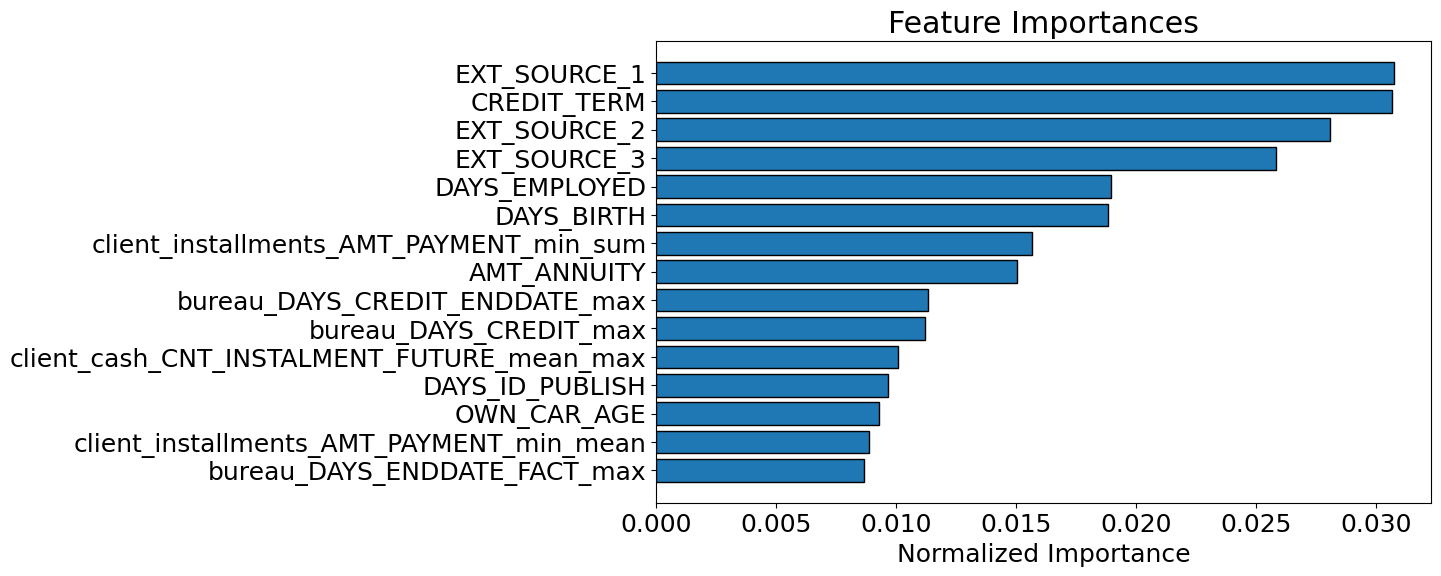

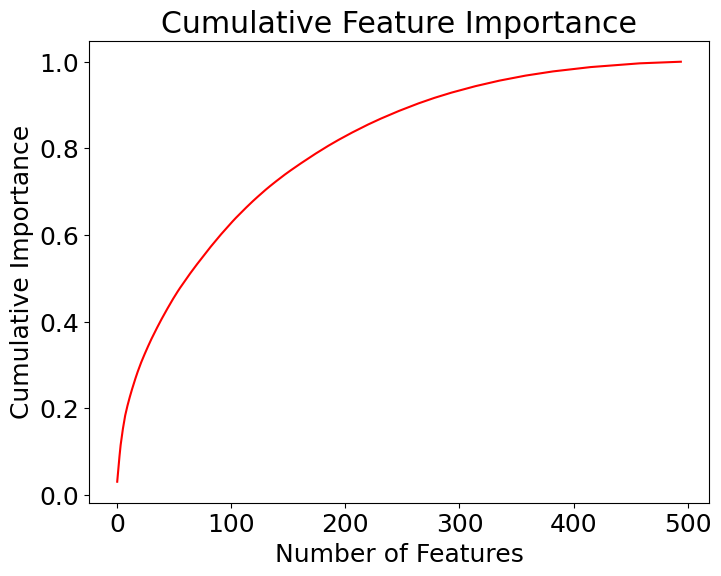

326 features required for 0.95 of cumulative importance


In [56]:
norm_feature_importances = plot_feature_importances(feature_importances)

## 6.4 - Sauvegarde d'un dataframe avec une sélection de features représentant 95% de la feature importance cumulée

In [57]:
# Threshold for cumulative importance
threshold = 0.95

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_reduced = df_train_without_corr_mv_zero_zero[features_to_keep]
test_reduced = df_test_without_corr_mv_zero_zero[features_to_keep]


In [58]:
# Ajout de la target et des id clients
train_reduced['TARGET'] = df_train_labels
train_reduced['SK_ID_CURR'] = df_train_ids
test_reduced['SK_ID_CURR'] = df_test_ids

In [59]:
print('Training shape: ', train_reduced.shape)
print('Testing shape: ', test_reduced.shape)

Training shape:  (307511, 327)
Testing shape:  (48744, 326)


In [62]:
train_reduced['NAME_EDUCATION_TYPE_Higher education'].unique()


array([False,  True])

In [63]:
test_reduced['NAME_EDUCATION_TYPE_Higher education'].unique()

array([ True, False])

In [57]:
train_reduced.to_csv('train_reduced.csv', index=False)
test_reduced.to_csv('test_reduced.csv', index=False)